In [1]:
from math import sqrt
from numpy import concatenate
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from matplotlib import pyplot

from IPython.display import display
import pickle

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(data) is list else data.shape[1] # сколько свойств у вектора наблюдений 
    #(если это список, то свойств 1)
    
    print('n_vars: ', n_vars)
    
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i)) # создание списка датафреймов со сдвигами данных по строкам
        names += [f"var{j+1}(t-{i})" for j in range(n_vars)] # для каждой переменной 
        #свое уникальное название внутри кажой строки
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i)) # создание списка датафреймов со сдвигами данных по строкам
        
        if i == 0:
            names += [f"var{j+1}(t)" for j in range(n_vars)]# для каждой переменной
                #свое уникальное название внутри кажой строки
        else:
            names += [f"var{j+1}(t+{i})" for j in range(n_vars)]# для каждой переменной
                #свое уникальное название внутри кажой строки
            
            
    # put it all together
    agg = concat(cols, axis=1) # слепить датафреймы по оси х, (колво строк то же, кол-во столбцов * 6 (144/24))
    agg.columns = names # назначить имена всем 144 колонкам
    
    # drop rows with NaN values (удалить нулевые строки)
    # вот тут не понял, у нас в ряд 6 датафреймов в каждом из которых 5,4,3,2,1 нулевые строки нули, 
    # а в последнем ласт строка - 0. Тогда мы удалим первые 5 строк и последнюю. Но зачем это перечисление (5,4,3,2,1),
    # если можно было во всех фреймах 5 строк обнулить через шифты 
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [3]:
dataset = read_csv('sensordata.csv', header = 0, index_col=0) # чтение данных из файла-таблицы в виде датафрейма, где 
# за названия столбцов берется 0 строка, а за названгия строк 0 столбец

In [4]:
values = dataset.values # преобразоваине датасета в np.array

In [5]:
# ensure all data is float
values = values.astype('float32') # приведение всех значений матрицы к типу данных float32

In [6]:
# normalise features
scaler = MinMaxScaler(feature_range=(0,1)) # определение функции нормализации
scaled = scaler.fit_transform(values) # передача матрицы в функцию нормализации

In [7]:
# frame as supervised learning
n_mins = 5 # кол-во строк (минут) используемых для предсказания следующего значения
n_features = 24 # кол-во свойств в каждой строке

reframed = series_to_supervised(scaled, n_mins, 1) # передаем нормализованную матрицу, 
#кол-во строк, на основании которых делается предсказание и кол-во предсказываемых строк
# и получаем склеенный датафрейм из строк равных колву строк scaled - 6, и 144 столбцами 
#(последные 24 столбца типо предсказываемое значение)

n_vars:  24


In [8]:
# split into train and test sets
values = reframed.values # преобразование датасета в матрицу numpy

n_train_mins = 4 * 24 * 60 # кол-во строк тренировочной выборки

train = values[:n_train_mins, :] # срезом определяем тренировочную выборку
test = values[n_train_mins:, :] # срезом определяем тестовуб выборку

In [9]:
# split into input and outputs
n_obs = n_mins * n_features # кол-во столбцов, описывающих, данные, на основе которых делается предсказание
# (в тех же values 144 столбца, 120 из них данные для предсказания, и последние 24 эталонные значения)

train_X, train_y = train[:, :n_obs], train[:, -1] # деление на входные тренировочные значения и выходные
# Вместо -1 можно брать любое значение var (var1 or var2 or etc)

test_X,  test_y =test[:, :n_obs], test[:,-1]  # деление на входные тестовые значения и выходные
# Вместо -1 можно брать любое значение var (var1 or var2 or etc)


In [10]:
# design svm model
clf = SVR()

In [11]:
# fit model
clf.fit(train_X, train_y) # Какие параметры можно задавать нужны комментарии ?
# есть еще sample_weight, который вроде заранее определяет веса точек (мега мутное определение, но, наверное,
#это про то, что точкам, далеким от гиперплоскости можно выставить вес так, чтобы они учитывались в алгоритме)
# оригинал "Per-sample weights. Rescale C per sample. Higher weights force 
#the classifier to put more emphasis on these points."

SVR()

In [12]:
# make a prediction
predict_y = clf.predict(test_X)

yhat = predict_y.reshape(predict_y.shape[0], 1) # был список чисел, стал список списков чисел по 1 элементу

In [13]:
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -24:-1], yhat), axis=1) # сделал матрицу из 23 параметров + 1 предсказанный для будущего
inv_yhat = scaler.inverse_transform(inv_yhat) # привел к абсолютным величинам

inv_yhat = inv_yhat[:,-1] # перечислил столбцы в обратном порядке?

In [14]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1)) # был список чисел, стал список списков чисел по 1 элементу

inv_y = concatenate((test_X[:, -24:-1], test_y), axis=1) # сделал матрицу из 23 параметров + 1 эталонный для будущего
inv_y = scaler.inverse_transform(inv_y) # привел к абсолютным величинам

inv_y = inv_y[:,-1] # перечислил столбцы в обратном порядке?

In [15]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat)) # считает ошибку по mean_squared_error
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.941


In [16]:
# calculate MAPE
mape = np.mean(np.fabs((inv_y - inv_yhat) / inv_y)) * 100 # средняя разница между правильными и предсказанными значениями?
print('Test mape: %d' % mape)

Test mape: 6


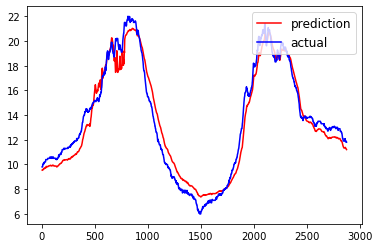

In [17]:
# plot всякие рисования
pyplot.plot([x for x in range(1, inv_yhat.shape[0]+1)], inv_yhat, linestyle='-', color='red', label='prediction')
pyplot.plot([x for x in range(1, inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='actual')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()

In [18]:
filename = "CVS_model.sav"
pickle.dump(clf, open(filename, 'wb'))